<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [2]:
from google.colab import drive

drive.mount('/content/drive')
!tar -xvf drive/MyDrive/cable.tar.gz cable

Mounted at /content/drive
tar: drive/MyDrive/cable.tar.gz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [88]:
#new
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

# 讀取數據集（僅使用 good 類別來訓練 Autoencoder）
data_paths = glob.glob('/content/drive/MyDrive/pill/pill/train/good/*.png')

def load_images(paths, img_size=(224, 224)):
    data = []
    for img_path in tqdm(paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)  # 調整大小
        img = img / 255.0  # 標準化
        data.append(img)
    return np.array(data, dtype=np.float32)

# 載入圖片
all_data = load_images(data_paths)
print(f"Dataset shape: {all_data.shape}")
import torchvision.transforms as transforms

import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, images, augment=False):
        self.images = images
        self.augment = augment
        self.transform = transforms.Compose([
            transforms.ToPILImage(),  # 轉為 PIL 影像
            transforms.RandomHorizontalFlip(p=0.5),  # 50% 機率水平翻轉
            transforms.RandomRotation(degrees=15),  # 隨機旋轉 ±15 度
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 亮度對比度變化
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # 隨機裁剪
            transforms.ToTensor()  # 轉為 Tensor
        ])
        self.to_tensor = transforms.ToTensor()  # 基本轉換（無增強）

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.augment:
            img = self.transform(img)
        else:
            img = self.to_tensor(img)
        return img


# 建立 DataLoader（訓練時使用資料增強）
dataset = ImageDataset(all_data, augment=True)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

100%|██████████| 267/267 [00:10<00:00, 25.54it/s]


Dataset shape: (267, 224, 224, 3)


In [89]:
import torch
import torch.nn as nn
import torchvision.models as models


class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()

        #  使用預訓練的 ResNet18 作為 Encoder
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # 移除 avgpool 和 FC 層

        #  Decoder
        # Decoder：逐步恢復到 224x224
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1), # 7x7 -> 14x14
        nn.ReLU(),
        nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14 -> 28x28
        nn.ReLU(),
        nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),   # 28x28 -> 56x56
        nn.ReLU(),
        nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, output_padding=1),    # 56x56 -> 112x112
        nn.ReLU(),
        nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),      # 112x112 -> 224x224
        nn.Sigmoid()
    )
    def forward(self, x):
        x = self.encoder(x)  # ResNet Encoder
        x = self.decoder(x)  # CNN Decoder
        return x



# 設置模型、損失函數和優化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 訓練 Autoencoder
epochs = 25
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images in data_loader:
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss/len(data_loader):.4f}")

# 儲存訓練好的模型
torch.save(model.state_dict(), "UNetAutoencoder.pth")
print("Autoencoder 訓練完成，模型已儲存。")

Epoch [1/25], Loss: 0.1077
Epoch [2/25], Loss: 0.0368
Epoch [3/25], Loss: 0.0236
Epoch [4/25], Loss: 0.0189
Epoch [5/25], Loss: 0.0114
Epoch [6/25], Loss: 0.0069
Epoch [7/25], Loss: 0.0051
Epoch [8/25], Loss: 0.0048
Epoch [9/25], Loss: 0.0046
Epoch [10/25], Loss: 0.0048
Epoch [11/25], Loss: 0.0048
Epoch [12/25], Loss: 0.0050
Epoch [13/25], Loss: 0.0047
Epoch [14/25], Loss: 0.0042
Epoch [15/25], Loss: 0.0042
Epoch [16/25], Loss: 0.0042
Epoch [17/25], Loss: 0.0043
Epoch [18/25], Loss: 0.0041
Epoch [19/25], Loss: 0.0040
Epoch [20/25], Loss: 0.0040
Epoch [21/25], Loss: 0.0040
Epoch [22/25], Loss: 0.0039
Epoch [23/25], Loss: 0.0038
Epoch [24/25], Loss: 0.0038
Epoch [25/25], Loss: 0.0033
Autoencoder 訓練完成，模型已儲存。


100%|██████████| 141/141 [00:05<00:00, 27.28it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AUC: 0.7147
Best threshold by ROC = 0.0029


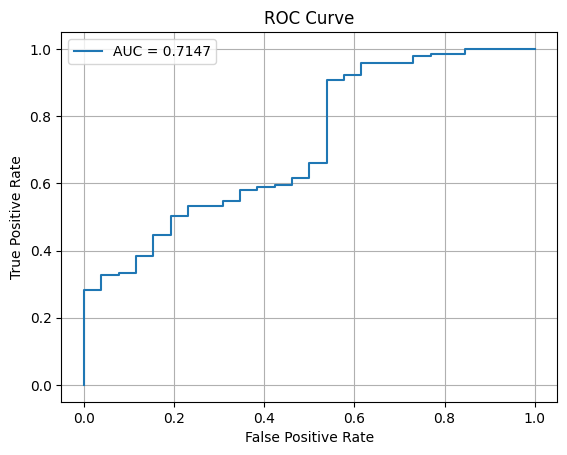

整體分類準確率: 0.8323
正常樣本準確率: 0.4615
異常樣本準確率: 0.9007


In [90]:
import glob
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# ===== 自訂 Dataset 和影像載入函數 =====
class ImageDataset(Dataset):
    def __init__(self, images, augment=False):
        self.images = images
        self.augment = augment
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
            transforms.ToTensor()
        ])
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        if self.augment:
            img = self.transform(img)
        else:
            img = self.to_tensor(img)
        return img

def load_images(paths, img_size=(224, 224)):
    data = []
    for img_path in tqdm(paths):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img / 255.0
        data.append(img)
    return np.array(data, dtype=np.float32)

# ===== 測試資料路徑 =====
test_good_paths = glob.glob('/content/drive/MyDrive/pill/pill/test/good/*.png')
test_anomaly_paths = glob.glob('/content/drive/MyDrive/pill/pill/test/*/*.png')

# 過濾異常樣本（排除 good）
test_anomaly_paths = [p for p in test_anomaly_paths if "good" not in p]

# ===== 載入測試圖片 =====
test_good_images = load_images(test_good_paths)
test_anomaly_images = load_images(test_anomaly_paths)

test_good_dataset = ImageDataset(test_good_images, augment=False)
test_anomaly_dataset = ImageDataset(test_anomaly_images, augment=False)

test_good_loader = DataLoader(test_good_dataset, batch_size=16, shuffle=False)
test_anomaly_loader = DataLoader(test_anomaly_dataset, batch_size=16, shuffle=False)

# ===== 載入模型 =====
class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super(ResNetAutoencoder, self).__init__()
        resnet = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])  # 去掉 avgpool 和 fc 層

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, 3, 2, 1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, 2, 1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetAutoencoder().to(device)
model.load_state_dict(torch.load("UNetAutoencoder.pth", map_location=device))
model.eval()

# ===== 計算重建誤差 =====
normal_errors = []
anomaly_errors = []

with torch.no_grad():
    for img in test_good_loader:
        img = img.to(device)
        output = model(img)
        mse = nn.functional.mse_loss(output, img, reduction='none')
        mse = mse.view(mse.size(0), -1).mean(dim=1)
        normal_errors.extend(mse.cpu().numpy())

    for img in test_anomaly_loader:
        img = img.to(device)
        output = model(img)
        mse = nn.functional.mse_loss(output, img, reduction='none')
        mse = mse.view(mse.size(0), -1).mean(dim=1)
        anomaly_errors.extend(mse.cpu().numpy())

# ===== ROC 分析 =====
y_true = [0] * len(normal_errors) + [1] * len(anomaly_errors)
y_score = np.concatenate([normal_errors, anomaly_errors])

fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc = roc_auc_score(y_true, y_score)
print(f"AUC: {auc:.4f}")

youden_index = tpr - fpr
best_threshold = thresholds[np.argmax(youden_index)]
print(f"Best threshold by ROC = {best_threshold:.4f}")

# ===== ROC 曲線圖 =====
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# ===== 最終分類表現 =====
preds = np.array(y_score) > best_threshold
accuracy = (preds == np.array(y_true)).mean()
print(f"整體分類準確率: {accuracy:.4f}")

normal_acc = (np.array(preds[:len(normal_errors)]) == 0).mean()
anomaly_acc = (np.array(preds[len(normal_errors):]) == 1).mean()

print(f"正常樣本準確率: {normal_acc:.4f}")
print(f"異常樣本準確率: {anomaly_acc:.4f}")
